In [23]:
import os

import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [24]:
data_arr = np.load("../data/data_unfiltered.npy")
run_arr = np.load("../data/runs_unfiltered.npy")

# Using a reference run
train_data = data_arr[run_arr == 379456]
train_data

array([[1006.,  830.,  253., ...,    0.,    0.,    0.],
       [ 788.,  653.,  221., ...,    0.,    0.,    0.],
       [ 966.,  775.,  295., ...,    0.,    0.,    0.],
       ...,
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.]])

In [25]:
x_train, x_val = train_test_split(train_data, test_size=0.2)

display(x_train.shape)
display(x_val.shape)

(961, 51)

(241, 51)

In [26]:
class PreprocessingLayer(torch.nn.Module):
    def forward(self, inputs: torch.Tensor):
        min_val = inputs.min(axis=0).values
        max_val = inputs.max(axis=0).values
        normalized_inputs = torch.where(
            (max_val - min_val) != 0,
            (inputs - min_val) / (max_val - min_val + 1e-8),
            torch.zeros_like(inputs)
        )
        return normalized_inputs

In [27]:
class Autoencoder(torch.nn.Module):
    def __init__(self, input_shape: tuple[int], l2_lambda: float):
        super().__init__()
        self.l2_lambda = torch.tensor(l2_lambda)
        self.prep_layer = PreprocessingLayer()
        self.encoder1 = torch.nn.Linear(input_shape[0], 18)
        self.encoder1_activation = torch.nn.ReLU()
        self.encoder2 = torch.nn.Linear(18, 8)
        self.encoder2_activation = torch.nn.Sigmoid()
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(8, 18),
            torch.nn.Sigmoid(),
            torch.nn.Linear(18, input_shape[0]),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        prep = self.prep_layer(x)
        encoded = self.encoder1(prep)
        encoded = self.encoder1_activation(encoded)
        l2_activity_loss = self.l2_lambda * torch.sum(encoded ** 2)
        encoded = self.encoder2(encoded)
        encoded = self.encoder2_activation(encoded)
        decoded = self.decoder(encoded)
        return decoded, l2_activity_loss
    
    def fit(self, inputs: np.ndarray, val_inputs: np.ndarray, batch_size: int, epochs: int, optimizer, criterion, patience: int, min_delta: float):
        inputs = torch.tensor(inputs.astype(np.float32))
        val_inputs = torch.tensor(val_inputs.astype(np.float32))
        targets = PreprocessingLayer()(inputs)
        val_targets = PreprocessingLayer()(val_inputs)
        batched_data = DataLoader(targets, batch_size=batch_size, shuffle=True)
        batch_steps = len(batched_data)
        training_loss = []
        validation_loss = []
        min_validation_loss = np.float32('inf')
        early_stop_counter = 0

        for epoch in range(epochs):
            self.train()
            epoch_decoder_losses = []
            epoch_val_losses = []
            epoch_total_losses = []
            epoch_total_val_losses = []
            for idx, batch in enumerate(batched_data):
                # Forward pass
                decoded, l2_loss = self(batch)
                loss = criterion(batch, decoded)
                loss_value = loss.item()
                epoch_decoder_losses.append(loss_value)

                # Compute total loss
                total_loss = loss + l2_loss
                total_loss_value = total_loss.item()  # This slows down the code if using GPU, since we convert this value from CUDA to a python float
                epoch_total_losses.append(total_loss_value)

                # Compute validation loss
                decoded, l2_loss = self(val_targets)
                val_loss = criterion(val_targets, decoded)
                val_loss_value = val_loss.item()
                epoch_val_losses.append(val_loss_value)

                # Compute total validation loss
                total_val_loss = val_loss + l2_loss
                total_val_loss_value = total_val_loss.item()
                epoch_total_val_losses.append(total_val_loss_value)
                
                # Backward pass and optimization
                optimizer.zero_grad()
                total_loss.backward()
                optimizer.step()

                # print(f"Epoch [{epoch + 1}/{epochs}], Step [{idx + 1}/{batch_steps}], decoder loss: {loss_value:.4f}, encoder1_activation l2 loss: {l2_loss:.4f}, total loss: {total_loss_value:.4f}")

            epoch_decoder_avg_loss = np.array(epoch_decoder_losses).mean()
            epoch_val_avg_loss = np.array(epoch_val_losses).mean()
            epoch_total_avg_loss = np.array(epoch_total_losses).mean()
            epoch_total_val_avg_loss = np.array(epoch_total_val_losses).mean()
            training_loss.append(epoch_total_avg_loss)
            validation_loss.append(epoch_total_val_avg_loss)

            # Early stopping - Stop training when a monitored metric has stopped improving.
            if epoch_total_val_avg_loss < (min_validation_loss + min_delta):
                min_validation_loss = epoch_total_val_avg_loss
                early_stop_counter = 0
            else:
                early_stop_counter += 1

            if early_stop_counter >= patience:
                break

            print(f"Epoch [{epoch + 1}/{epochs}] (avg {batch_steps} steps): decoder loss: {epoch_decoder_avg_loss:.4f}, total loss: {epoch_total_avg_loss:.4f}, validation loss: {epoch_val_avg_loss:.4f}, total validation loss: {epoch_total_val_avg_loss:.4f}")
        
        return training_loss, validation_loss

In [28]:
class InferenceAutoencoder(Autoencoder):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.mse_loss = torch.nn.MSELoss(reduction='none')

    def forward(self, x):
        prep = self.prep_layer(x)
        encoded = self.encoder1(prep)
        encoded = self.encoder1_activation(encoded)
        encoded = self.encoder2(encoded)
        encoded = self.encoder2_activation(encoded)
        decoded = self.decoder(encoded)
        mse = self.mse_loss(prep, decoded)
        avg_mse = torch.mean(mse, dim=1)
        return decoded, avg_mse

In [29]:
ae = Autoencoder(input_shape=(51,), l2_lambda=1e-4)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(ae.parameters(), lr=0.001, eps=1e-07)

In [30]:
training_loss, validation_loss = ae.fit(x_train, x_val, 128, 500, optimizer, criterion, patience=5, min_delta=0)

Epoch [1/500] (avg 8 steps): decoder loss: 0.2083, total loss: 0.2103, validation loss: 0.2088, total validation loss: 0.2129
Epoch [2/500] (avg 8 steps): decoder loss: 0.1908, total loss: 0.1919, validation loss: 0.1915, total validation loss: 0.1938
Epoch [3/500] (avg 8 steps): decoder loss: 0.1746, total loss: 0.1752, validation loss: 0.1754, total validation loss: 0.1766
Epoch [4/500] (avg 8 steps): decoder loss: 0.1593, total loss: 0.1596, validation loss: 0.1603, total validation loss: 0.1610
Epoch [5/500] (avg 8 steps): decoder loss: 0.1450, total loss: 0.1452, validation loss: 0.1463, total validation loss: 0.1467
Epoch [6/500] (avg 8 steps): decoder loss: 0.1317, total loss: 0.1318, validation loss: 0.1331, total validation loss: 0.1334
Epoch [7/500] (avg 8 steps): decoder loss: 0.1193, total loss: 0.1193, validation loss: 0.1209, total validation loss: 0.1210
Epoch [8/500] (avg 8 steps): decoder loss: 0.1078, total loss: 0.1078, validation loss: 0.1095, total validation loss:

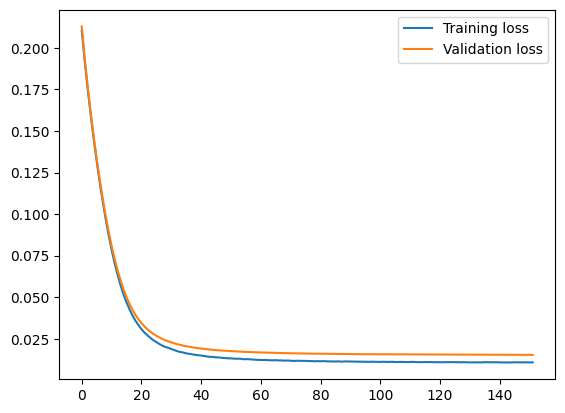

In [31]:
plt.plot(training_loss, label="Training loss")
plt.plot(validation_loss, label="Validation loss")
plt.legend()
plt.show()

In [32]:
iae = InferenceAutoencoder(input_shape=(51,), l2_lambda=1e-4)
iae.load_state_dict(ae.state_dict())

<All keys matched successfully>

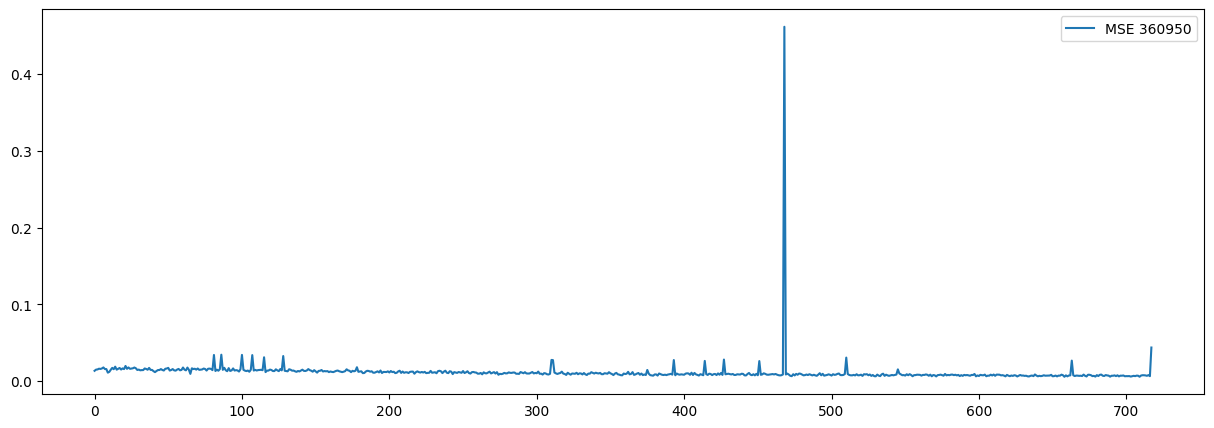

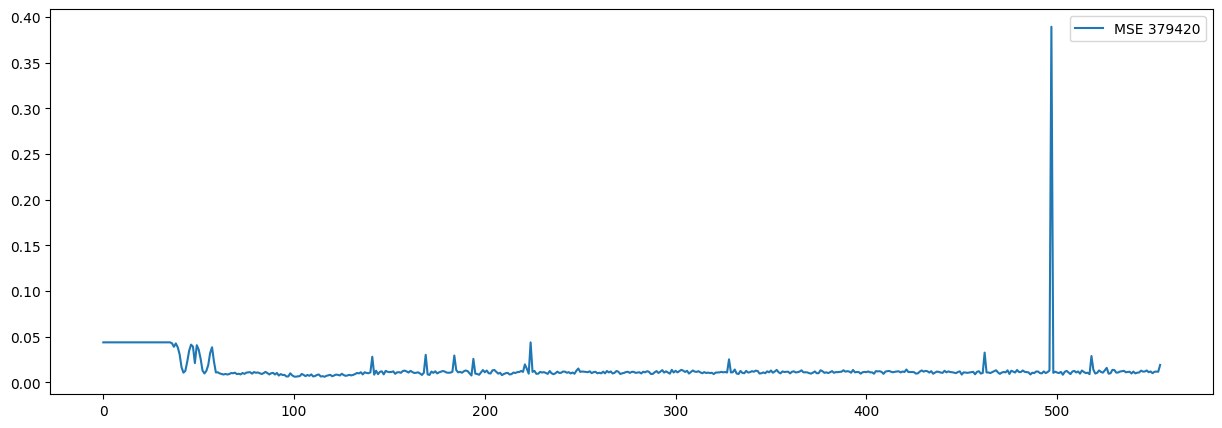

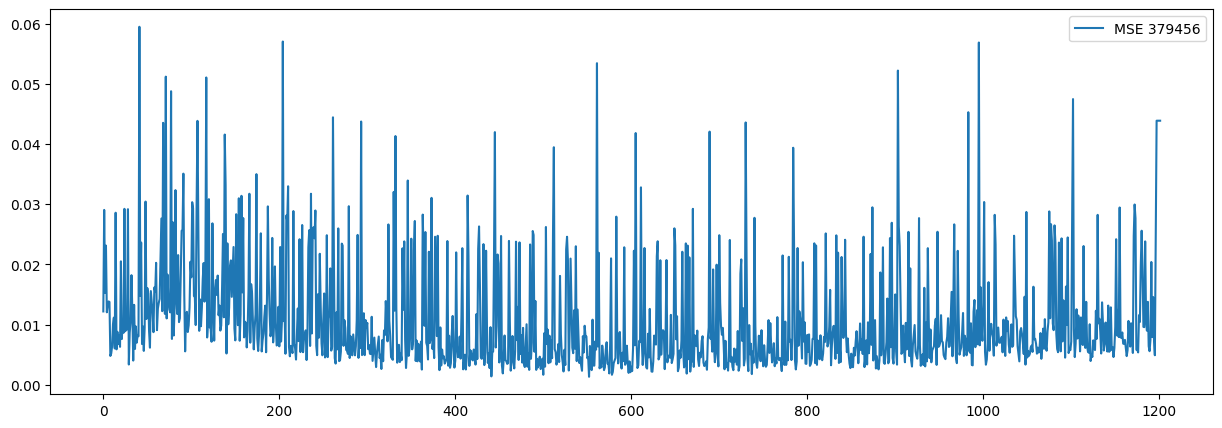

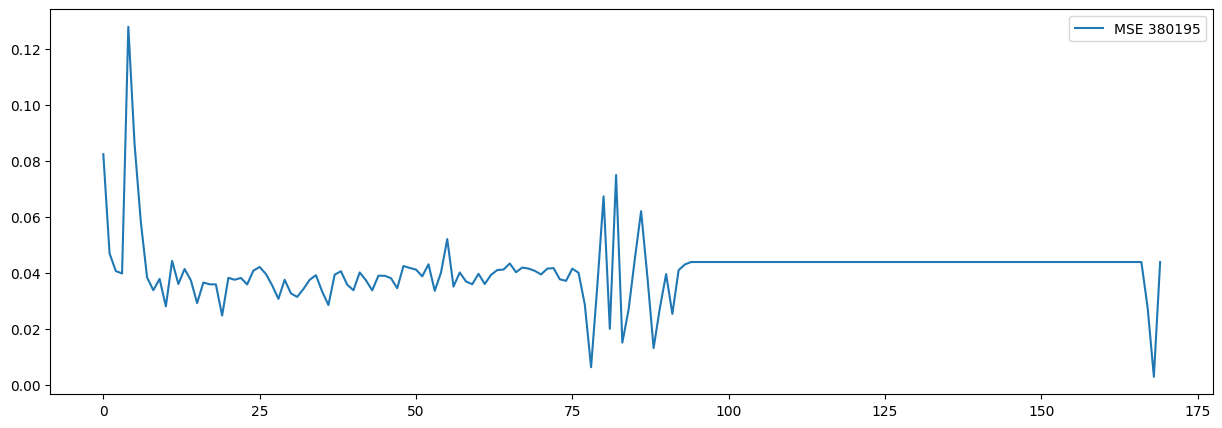

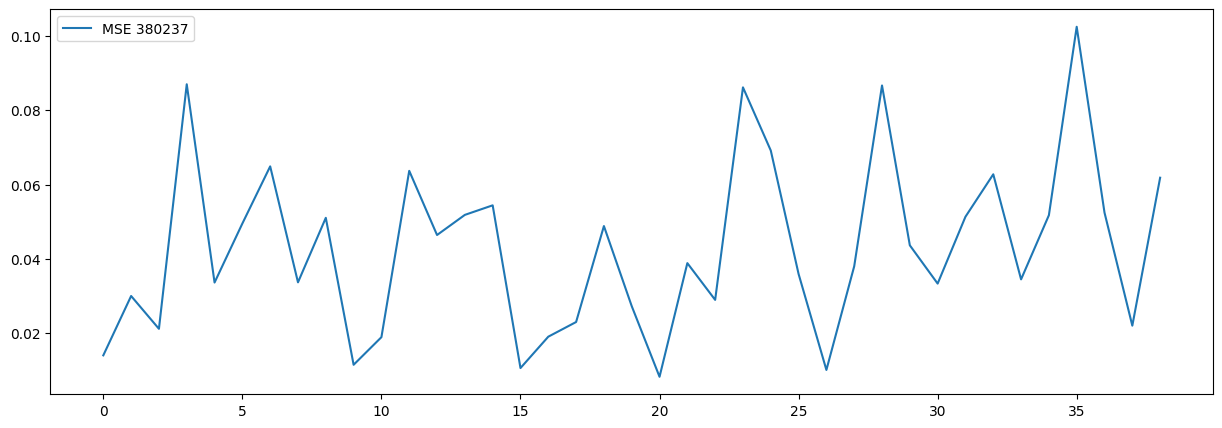

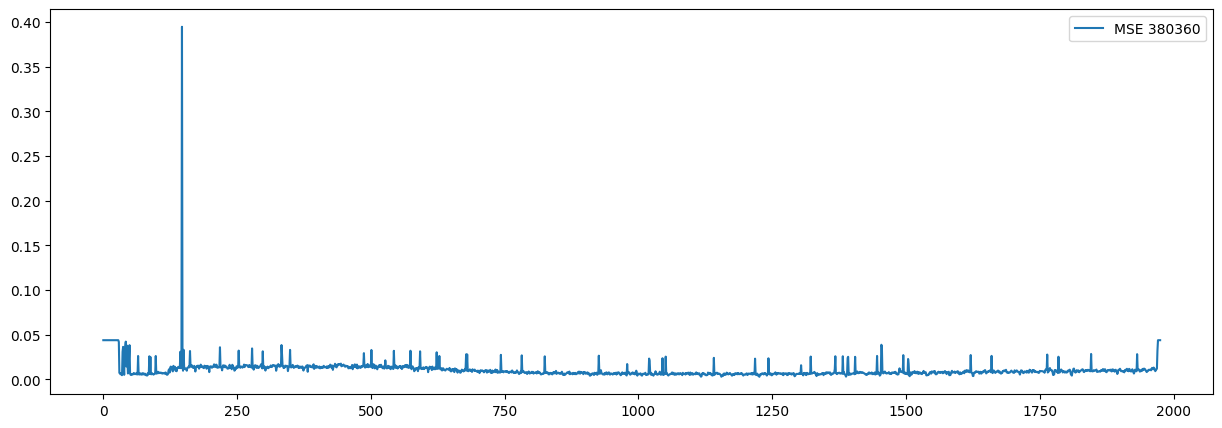

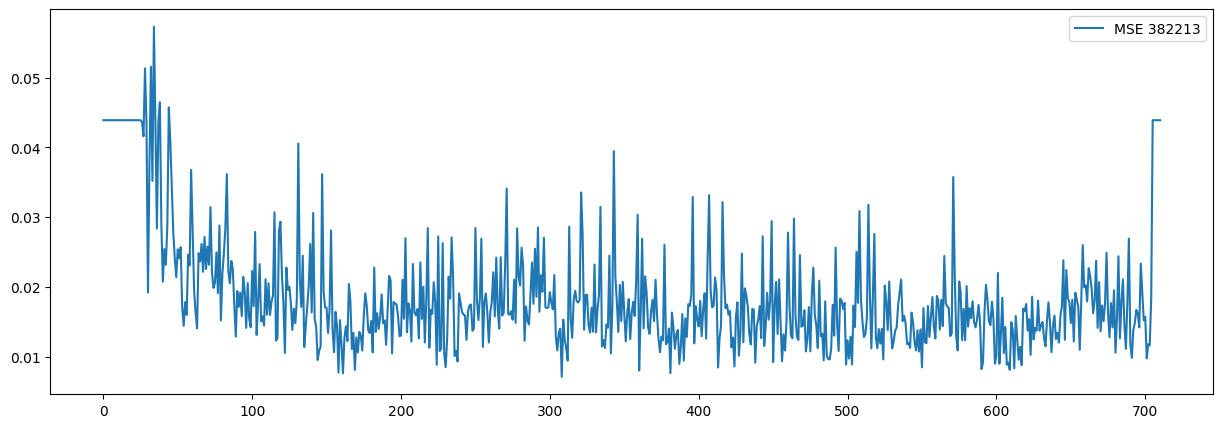

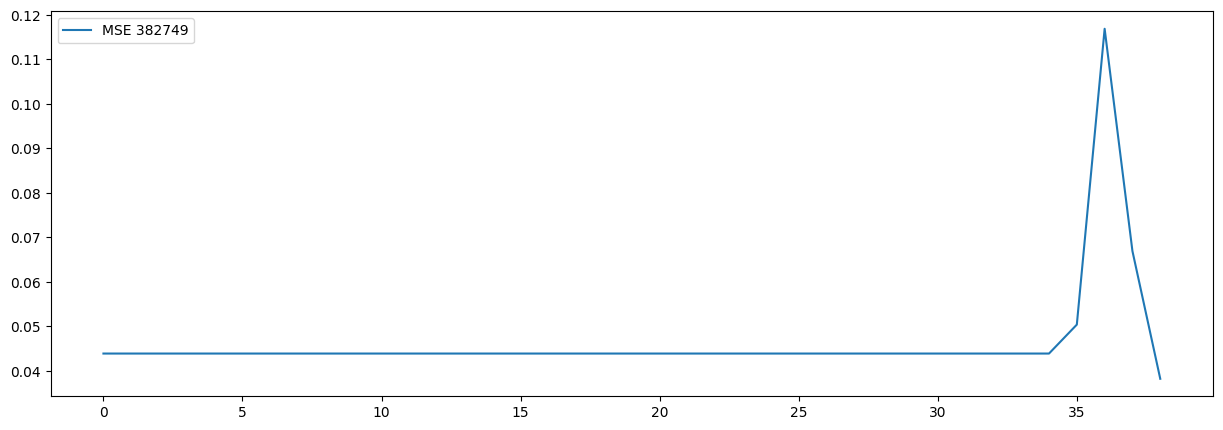

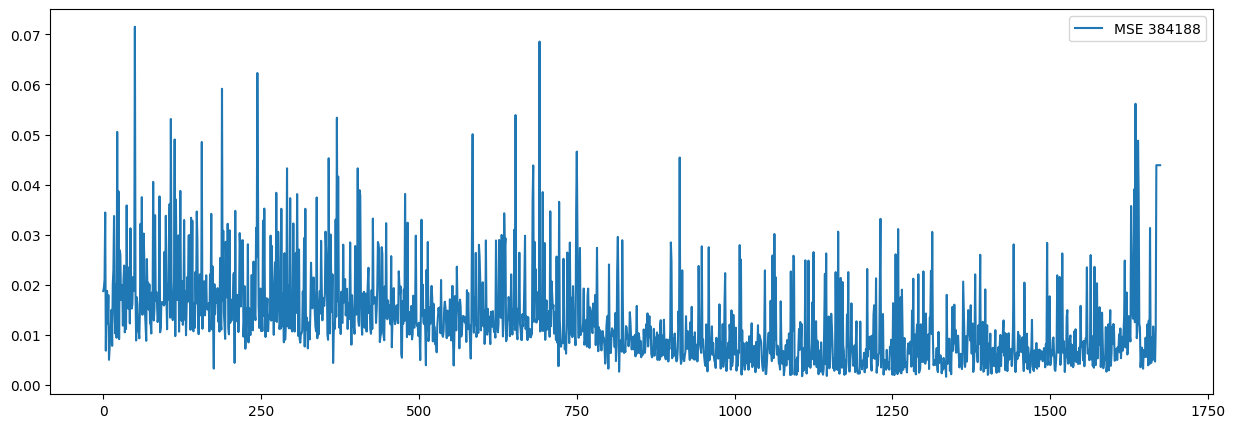

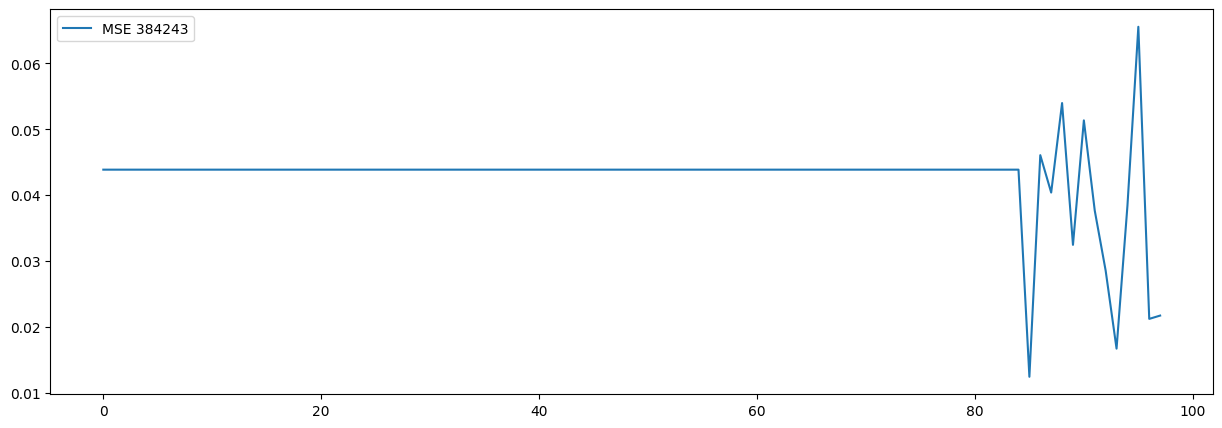

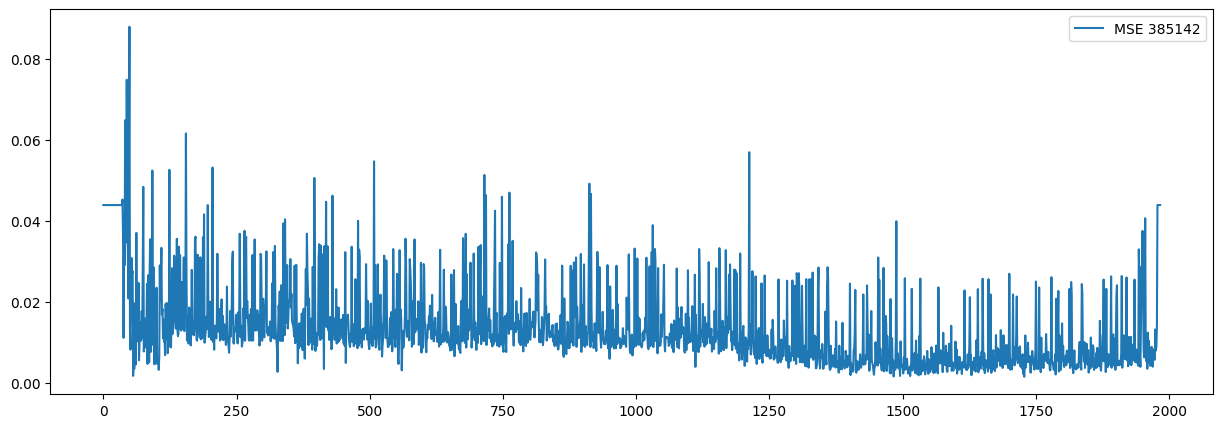

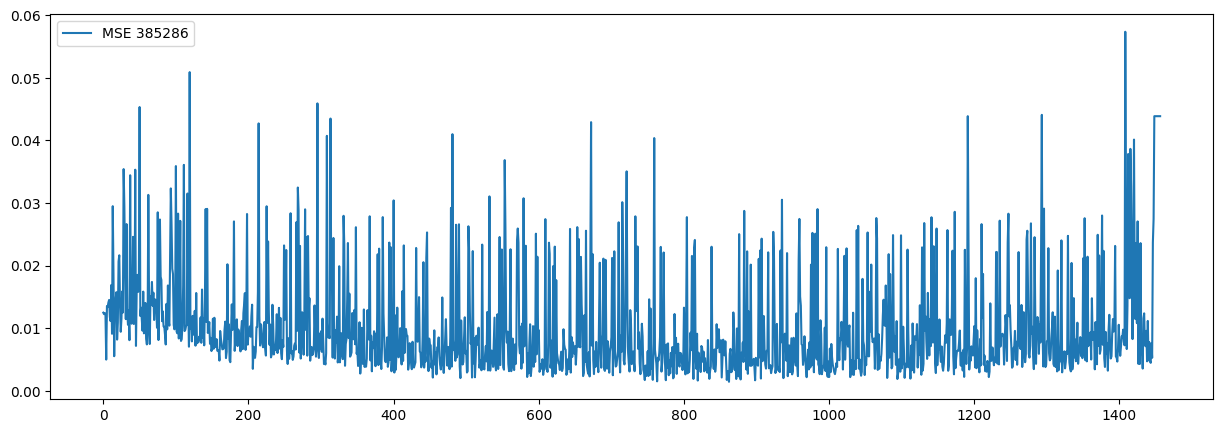

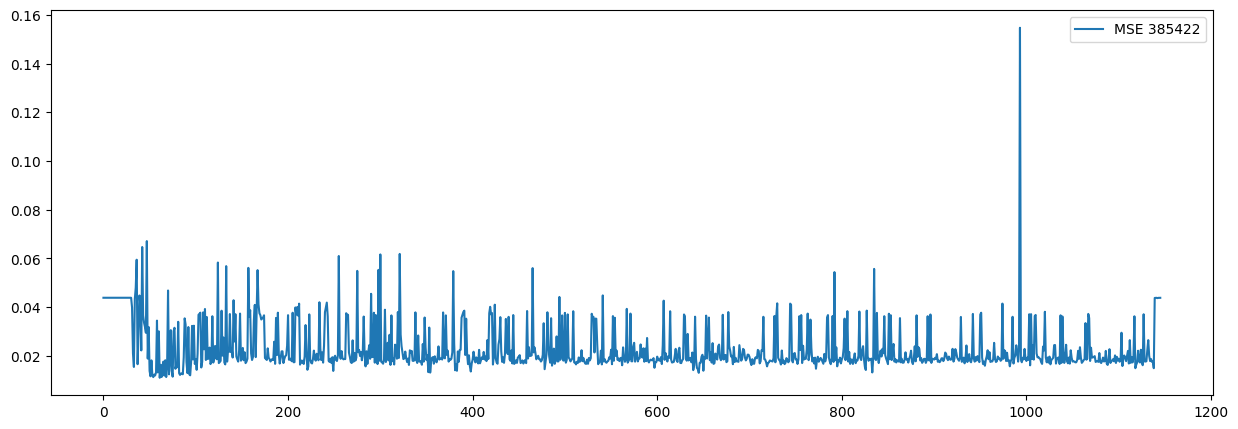

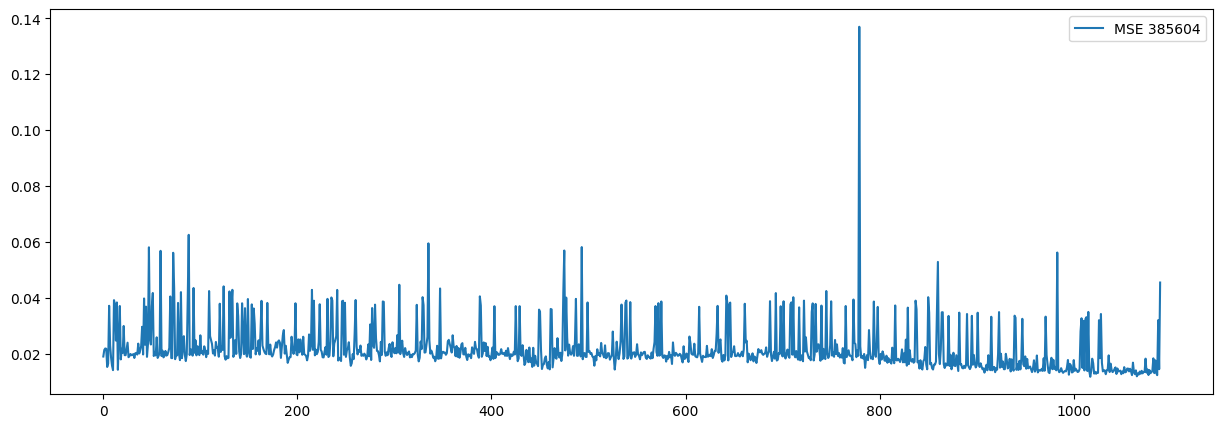

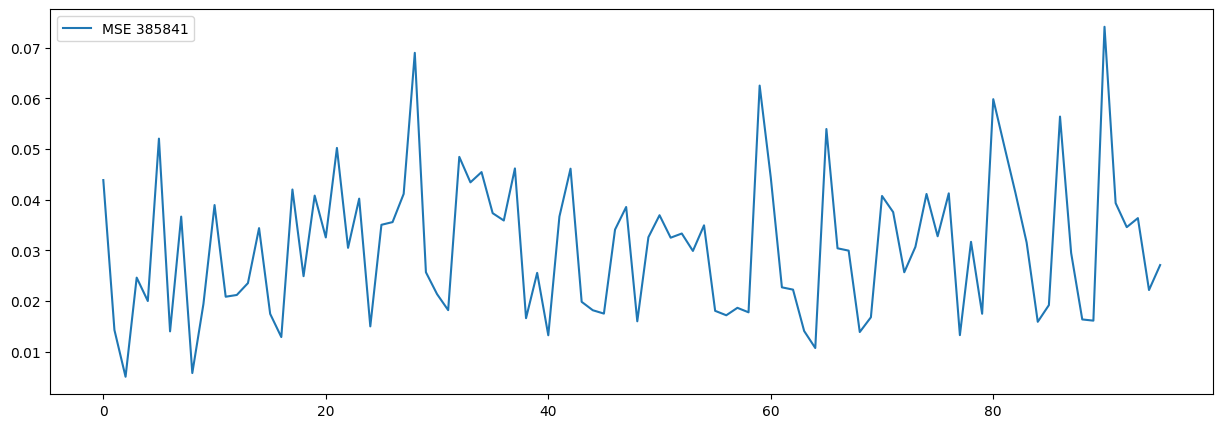

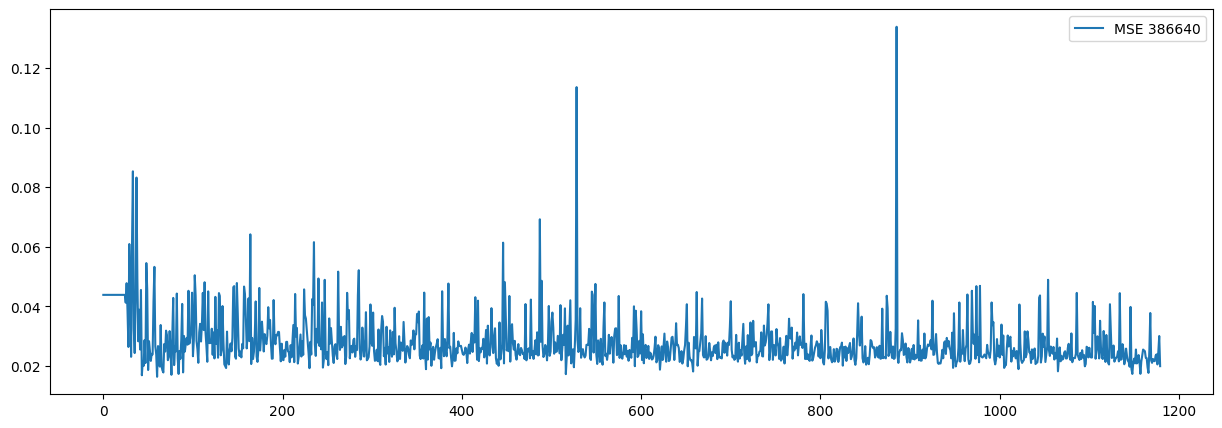

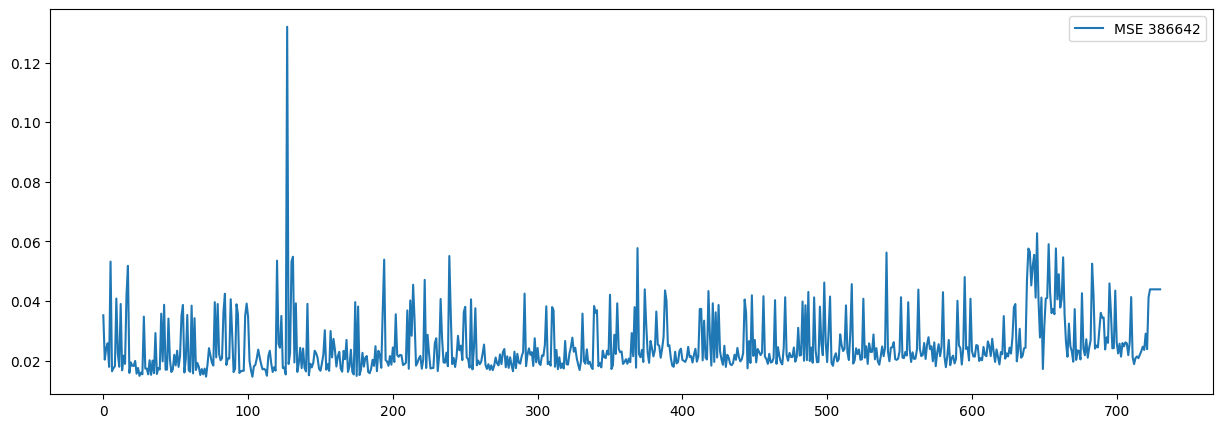

In [33]:
for run_number in np.unique(run_arr):
    run_data = data_arr[run_arr == run_number].astype(np.float32)
    run_data = torch.tensor(run_data)
    _, avg_mse = iae(run_data)
    avg_mse = avg_mse.detach().numpy()

    plt.figure(figsize=(15, 5))
    plt.plot(range(avg_mse.shape[0]), avg_mse, label=f"MSE {run_number}")
    plt.legend()
    plt.show()
    plt.close()

In [34]:
os.makedirs("../models/torch", exist_ok=True)

model_path = "../models/torch/state_dict.pth"
torch.save(iae.state_dict(), model_path)

In [35]:
os.makedirs("../models/torch_as_onnx_ops21", exist_ok=True)

# https://pytorch.org/tutorials/beginner/onnx/export_simple_model_to_onnx_tutorial.html
#
# Even though it raises this warning:
#
# UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, 
# and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' 
# Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
#
# The model is working fine when deployed through NVIDIA tritonserver.
# If you replace `dynamic_axes` with `dynamic_shapes`, the output
# graph doesn't have dynamic size for the configured fields.
dummy_inputs = torch.ones(10,51)
onnx_program = torch.onnx.export(
    iae,
    (dummy_inputs,),
    input_names=["input_0"],
    output_names=["reconstructed", "avg_mse"],
    dynamic_axes={
        "input_0": {0: "batch_size"},
        "reconstructed": {0: "batch_size"},
        "avg_mse": {0: "batch"}
    },
    dynamo=True,
    opset_version=21  # latset opset version for onnxruntime 1.20 and onnx 1.16.1 check here (https://onnxruntime.ai/docs/reference/compatibility.html#onnx-opset-support)
)
onnx_program.optimize()
onnx_program.save("../models/torch_as_onnx_ops21/model.onnx")

# You can use [netron](https://netron.app/) to inspect the onnx model

/home/gamoreir/.cache/pypoetry/virtualenvs/ml-examples-EfRPkUGI-py3.11/lib/python3.11/site-packages/torch/onnx/_internal/exporter/_compat.py:262: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  warnings.warn(
W0328 18:56:19.482000 622639 torch/onnx/_internal/exporter/_registration.py:66] torchvision is not installed. Skipping torchvision::nms


[torch.onnx] Obtain model graph for `InferenceAutoencoder([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `InferenceAutoencoder([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 1 of general pattern rewrite rules.


In [36]:
import onnx
import onnxruntime

# Check model consistency, an exception will be raised if something is wrong
onnx_model = onnx.load("../models/torch_as_onnx_ops21/model.onnx")
onnx.checker.check_model(onnx_model)

# Load the inference session and print input and output layers
# which are useful for creating the `config.pbtxt` file
# required by NVIDIA Triton Inference Server
sess = onnxruntime.InferenceSession("../models/torch_as_onnx_ops21/model.onnx")
_inputs = sess.get_inputs()
_outputs = sess.get_outputs()

print("inputs")
for _input in _inputs:
    print(_input)

print("\noutputs")
for _output in _outputs:
    print(_output)

# Generate a demo config.pbtxt
configs_inputs = "input [\n"
for idx, _input in enumerate(_inputs):
    shp = ["-1" if "s0" in str(value) else str(value) for value in _input.shape]
    dims = ", ".join(shp)
    configs_inputs += f"  {{\n    name: \"{_input.name}\"\n    data_type: TYPE_FP32\n    dims: [{dims}]\n  }}"
    if idx + 1 < len(_inputs):
        configs_inputs += ","
    configs_inputs += "\n"
configs_inputs += "]"

configs_outputs = "output [\n"
for idx, _output in enumerate(_outputs):
    shp = ["-1" if "s0" in str(value) else str(value) for value in _output.shape]
    dims = ", ".join(shp)
    configs_outputs += f"  {{\n    name: \"{_output.name}\"\n    data_type: TYPE_FP32\n    dims: [{dims}]\n  }}"
    if idx + 1 < len(_outputs):
        configs_outputs += ","
    configs_outputs += "\n"
configs_outputs += "]"

config_content = f"""name: "my_model"
platform: "onnxruntime_onnx"
max_batch_size: 0
{configs_inputs}
{configs_outputs}
"""

print()
print(config_content)

inputs
NodeArg(name='input_0', type='tensor(float)', shape=['s0', 51])

outputs
NodeArg(name='reconstructed', type='tensor(float)', shape=['s0', 51])
NodeArg(name='avg_mse', type='tensor(float)', shape=['s0'])

name: "my_model"
platform: "onnxruntime_onnx"
max_batch_size: 0
input [
  {
    name: "input_0"
    data_type: TYPE_FP32
    dims: [-1, 51]
  }
]
output [
  {
    name: "reconstructed"
    data_type: TYPE_FP32
    dims: [-1, 51]
  },
  {
    name: "avg_mse"
    data_type: TYPE_FP32
    dims: [-1]
  }
]



In [37]:
os.makedirs("../models/torch_as_onnx_ops20", exist_ok=True)

# https://pytorch.org/tutorials/beginner/onnx/export_simple_model_to_onnx_tutorial.html
#
# Even though it raises this warning:
#
# UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, 
# and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' 
# Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
#
# The model is working fine when deployed through NVIDIA tritonserver.
# If you replace `dynamic_axes` with `dynamic_shapes`, the output
# graph doesn't have dynamic size for the configured fields.
dummy_inputs = torch.ones(10,51)
onnx_program = torch.onnx.export(
    iae,
    (dummy_inputs,),
    input_names=["input_0"],
    output_names=["reconstructed", "avg_mse"],
    dynamic_axes={
        "input_0": {0: "batch_size"},
        "reconstructed": {0: "batch_size"},
        "avg_mse": {0: "batch"}
    },
    dynamo=True,
    opset_version=20  # KServe v0.15.0-rc1 is using NVIDIA tritonserver 2.34.0, wich only supports ONNX IR version up to 9.
)
onnx_program.optimize()
onnx_program.save("../models/torch_as_onnx_ops20/model.onnx")

# You can use [netron](https://netron.app/) to inspect the onnx model

/home/gamoreir/.cache/pypoetry/virtualenvs/ml-examples-EfRPkUGI-py3.11/lib/python3.11/site-packages/torch/onnx/_internal/exporter/_compat.py:262: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  warnings.warn(
W0328 18:56:20.244000 622639 torch/onnx/_internal/exporter/_registration.py:66] torchvision is not installed. Skipping torchvision::nms


[torch.onnx] Obtain model graph for `InferenceAutoencoder([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `InferenceAutoencoder([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 1 of general pattern rewrite rules.


In [38]:
import onnx
import onnxruntime

# Check model consistency, an exception will be raised if something is wrong
onnx_model = onnx.load("../models/torch_as_onnx_ops20/model.onnx")
onnx_model.ir_version = 9  # This is a hack, a proper solution would be installing an old onnx/onnxruntime/onnxscript version
onnx.checker.check_model(onnx_model)
onnx.save(onnx_model, "../models/torch_as_onnx_ops20/model.onnx")

# Load the inference session and print input and output layers
# which are useful for creating the `config.pbtxt` file
# required by NVIDIA Triton Inference Server
sess = onnxruntime.InferenceSession("../models/torch_as_onnx_ops20/model.onnx")
_inputs = sess.get_inputs()
_outputs = sess.get_outputs()

print("inputs")
for _input in _inputs:
    print(_input)

print("\noutputs")
for _output in _outputs:
    print(_output)

# Generate a demo config.pbtxt
configs_inputs = "input [\n"
for idx, _input in enumerate(_inputs):
    shp = ["-1" if "s0" in str(value) else str(value) for value in _input.shape]
    dims = ", ".join(shp)
    configs_inputs += f"  {{\n    name: \"{_input.name}\"\n    data_type: TYPE_FP32\n    dims: [{dims}]\n  }}"
    if idx + 1 < len(_inputs):
        configs_inputs += ","
    configs_inputs += "\n"
configs_inputs += "]"

configs_outputs = "output [\n"
for idx, _output in enumerate(_outputs):
    shp = ["-1" if "s0" in str(value) else str(value) for value in _output.shape]
    dims = ", ".join(shp)
    configs_outputs += f"  {{\n    name: \"{_output.name}\"\n    data_type: TYPE_FP32\n    dims: [{dims}]\n  }}"
    if idx + 1 < len(_outputs):
        configs_outputs += ","
    configs_outputs += "\n"
configs_outputs += "]"

config_content = f"""name: "my_model"
platform: "onnxruntime_onnx"
max_batch_size: 0
{configs_inputs}
{configs_outputs}
"""

print()
print(config_content)

inputs
NodeArg(name='input_0', type='tensor(float)', shape=['s0', 51])

outputs
NodeArg(name='reconstructed', type='tensor(float)', shape=['s0', 51])
NodeArg(name='avg_mse', type='tensor(float)', shape=['s0'])

name: "my_model"
platform: "onnxruntime_onnx"
max_batch_size: 0
input [
  {
    name: "input_0"
    data_type: TYPE_FP32
    dims: [-1, 51]
  }
]
output [
  {
    name: "reconstructed"
    data_type: TYPE_FP32
    dims: [-1, 51]
  },
  {
    name: "avg_mse"
    data_type: TYPE_FP32
    dims: [-1]
  }
]



In [39]:
os.makedirs("../models/torchscript", exist_ok=True)

# This exports the whole model as torchscript
# useful for deploying in NVIDIA Triton Iference Server
# https://github.com/triton-inference-server/tutorials/blob/main/Quick_Deploy/PyTorch/export.py
dummy_inputs = torch.ones(10,51)
traced_model = torch.jit.trace(iae, dummy_inputs)
torch.jit.save(traced_model, "../models/torchscript/model.pt")

In [43]:
# Inspect input and output signatures

model = torch.jit.load("../models/torchscript/model.pt")
model.eval()

dummy_inputs = torch.ones(10,51)
with torch.no_grad():
    output = model(dummy_inputs)

# Print input details
print("Inputs")
print(f"name=<Any> shape={dummy_inputs.shape}, dtype={dummy_inputs.dtype}")

# Print output details
print("\nOutputs")
if isinstance(output, torch.Tensor):  # Single output case
    print(f"name=<Any> shape={output.shape}, dtype={output.dtype}")
elif isinstance(output, (list, tuple)):  # Multiple outputs
    for i, out in enumerate(output):
        print(f"name=<Any_{i}> shape={out.shape}, dtype={out.dtype}")

Inputs
name=<Any> shape=torch.Size([10, 51]), dtype=torch.float32

Outputs
name=<Any_0> shape=torch.Size([10, 51]), dtype=torch.float32
name=<Any_1> shape=torch.Size([10]), dtype=torch.float32
